In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# uploading the dataset
df = pd.read_csv(r"C:\Users\m\Downloads\excel files\vehicles.csv")

In [3]:
df.shape

(426880, 26)

In [4]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

# Filtering inconsistent data

In [5]:
# useless columns
df.drop(['id', 'url', 'region_url', 'county', 'size',
         'image_url', 'description', 'posting_date'],
        axis = 1, inplace = True)

In [6]:
# price outliers
df = df[df['price'].between(1000, 100000)]
df.shape

(379910, 18)

In [7]:
# odometer outlier
df = df[df['odometer'] < 10**6]
df.shape

(377389, 18)

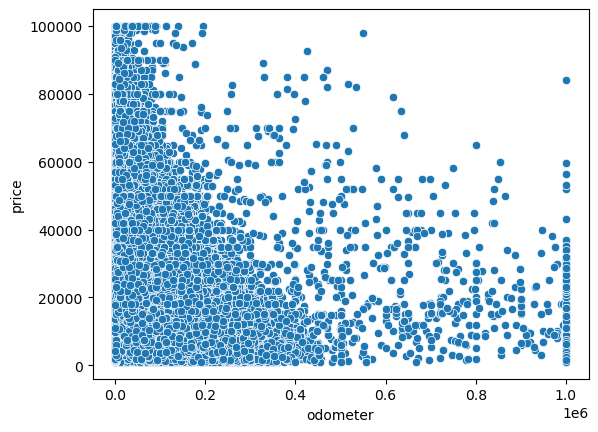

In [67]:
sns.scatterplot(x = 'odometer', y = 'price', data = df)
plt.show()

In [59]:
# droping cars with no manufacturer and model
df.dropna(subset = ['manufacturer', 'model'], how = 'all', inplace = True)
df.shape

(376644, 18)

In [69]:
# droping year 2022 and null years
df = df[df['year'] != 2022]
df.dropna(subset = 'year', inplace = True)
df.shape

(375578, 18)

# Fixing/Removing typos in the 'model'

In [26]:
# creating a mask for the condition
mask = ((df['model'].str.contains('^[\W\d]+$') == True) & (df['manufacturer'] == 'unknown'))
mask2 = ((df['model'].str.contains('[@%$*#%*!=]') == True) &  (df['manufacturer'] == 'unknown'))

# dropping typos with null manufacturer (unknown)
df = df[~mask]
df = df[~mask2]

# filling the remaining with 'unknown'
df.loc[df['model'].str.contains('^[\W\d]+$') == True, 'model'] = 'unknown'
df.loc[df['model'].str.contains('[@%$*#%*!=]') == True, 'model'] = 'unknown'

# dropping strange inputs
df = df[df['model'].str.contains('[♿🔥]') == False]
df = df[df['model'].str.contains('^[,-./]') == False]



# Imputing missing values

In [16]:
# filling paint_color with 'custom'
df['paint_color'] = df['paint_color'].fillna('custom')

In [17]:
# filling title_status with mode value
df['title_status'] = df['title_status'].fillna('clean')

In [18]:
# filling transmission with mode value
df['transmission'].fillna(df['transmission'].mode().iloc[0], inplace = True)

In [19]:
# filling fuel with mode value
df['fuel'].fillna(df['fuel'].mode().iloc[0], inplace = True)

In [20]:
# filling odometer with the median value
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

In [21]:
# convert VIN to binary

# replacing exsisting VINs with 1
df.loc[df['VIN'].notnull(), 'VIN'] = 1

# filling nulls with 0
df['VIN'].fillna(0, inplace = True)

In [22]:
# filling manufacturer and model 'unknown'
df['manufacturer'] = df['manufacturer'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')

# Lat & Long

In [24]:
# populating lat & long with the median value per each 'region'
regions = df['region'].unique()

# Fill missing lat and long based on median values for each region
for region in regions:
    median_lat = df[df['region'] == region]['lat'].median()
    median_long = df[df['region'] == region]['long'].median()
    df.loc[(df['region'] == region) & (df['lat'].isnull()), 'lat'] = median_lat
    df.loc[(df['region'] == region) & (df['long'].isnull()), 'long'] = median_long


# Populating type on model

In [73]:
models = df['model'].unique()

In [74]:
# empty lists to save the result
typ = []
model_type = []
models_null_type = []

for model in models:
    # type mode value
    mode_value = df[df['model'] == model]['type'].mode()
    
    if not mode_value.empty:
        
        # assining values to the lists
        model_type.append(model)
        typ.append(mode_value.iloc[0])
    else:
        # models with no mode value
        models_null_type.append(model)
        
# displaying the length of each list        
print(len(model_type), len(typ), len(models_null_type))  

21736 21736 4359


In [75]:
# filling nulls with the mode value per each 'model'
for i in range(min(len(model_type), len(typ))):
    
    df.loc[(df['type'].isnull()) & (df['model'] == model_type[i]), 'type'] = typ[i]

In [76]:
# filling remaining nulls with 'other'
df['type'].fillna('other', inplace = True)

# Populating drive on model

In [77]:
# empty lists to save the result
drive = []
model_drive = []
models_null_drive = []

for model in models:
    # drive mode value
    mode_value = df[df['model'] == model]['drive'].mode()
    
    if not mode_value.empty:
        
        # assining values to the lists
        model_drive.append(model)
        drive.append(mode_value.iloc[0])
    else:
        # models with no mode value
        models_null_drive.append(model)
        
# displaying the length of each list        
print(len(model_drive), len(drive), len(models_null_drive))

20562 20562 5533


In [78]:
# filling nulls with the mode value per each 'model' 
for i in range(min(len(model_drive), len(drive))):
    df.loc[(df['drive'].isnull()) & (df['model'] == model_drive[i]), 'drive'] = drive[i]

In [79]:
# filling remaining nulls with the mode of the entire column
df['drive'].fillna(df['drive'].mode().iloc[0], inplace = True)

In [80]:
# checking
df['drive'].isnull().sum()

0

# Populating Cylinders on model

In [81]:
cylinders = []
model_cylinders = []
models_null_cylinders = []

for model in models:
    cylinder_mode = df[df['model'] == model]['cylinders'].mode()
    
    if not cylinder_mode.empty:
        model_cylinders.append(model)
        cylinders.append(cylinder_mode.iloc[0])
    else:
        # types with no mode value
        models_null_cylinders.append(model)
print(len(model_cylinders), len(cylinders), len(models_null_cylinders))

19812 19812 6283


In [82]:
# filling nulls based on the vehicels 'type'
for i in range(min(len(model_cylinders), len(cylinders))):
    df.loc[(df['cylinders'].isnull()) & (df['model'] == model_cylinders[i]), 'cylinders'] = cylinders[i]

In [83]:
# filling remaining nulls with the mode of the entire column
df['cylinders'].fillna(df['drive'].mode().iloc[0], inplace = True)

In [84]:
# checking 
df['cylinders'].isnull().sum()

0

In [86]:
# checking the whole dataset
df.isnull().sum()

region               0
price                0
year                 0
manufacturer         0
model                0
condition       140778
cylinders            0
fuel                 0
odometer             0
title_status         0
transmission         0
VIN                  0
drive                0
type                 0
paint_color          0
state                0
lat                  0
long                 0
dtype: int64

In [89]:
df.shape

(375578, 18)

In [88]:
# Saving the results to a csv file for the next session
df.to_csv('Used_Cars_Clean_Data', index = False)